<a id="top"></a>
# Neural Posterior Estimation for Roman Microlensing

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

<a href="https://colab.research.google.com/github/rges-pit/data-challenge-notebooks/blob/main/Extras/nbi_roman_synthetic.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Goals

By the end of this notebook you will have learned to:

- Install and configure the **Neural Bayesian Inference (NBI)** package for microlensing analysis
- Set up a **Point-Source Point-Lens (PSPL)** microlensing forward model
- Configure **neural posterior estimation** with ResNet-GRU featurizers for time-series data
- Train an **amortized neural posterior estimator** using simulated Roman microlensing data
- Perform **rapid Bayesian inference** on synthetic light curves
- Compare neural posterior estimation with traditional MCMC approaches

In addition, you'll gain:
- Understanding of simulation-based inference for microlensing
- Experience with modern deep learning workflows for astronomical inference
- Knowledge of when to use NBI versus traditional fitting methods

## Introduction

This notebook demonstrates how to use **Neural Bayesian Inference (NBI)** for rapid parameter estimation of Roman microlensing events. NBI is a simulation-based inference framework that uses neural networks to learn posterior distributions directly from simulated data.

### Why Neural Posterior Estimation?

Traditional Bayesian inference methods like MCMC are powerful but face fundamental scalability challenges:

- **Computational cost**: Each MCMC run requires thousands of likelihood evaluations, taking hours to days per event
- **Manual tuning**: Proposal distributions, burn-in periods, and convergence diagnostics require expert intervention
- **Sequential nature**: Each event must be analyzed independently from scratch

Neural Posterior Estimation (NPE) addresses these limitations through **amortized inference**—the computational cost is paid once during training, and inference on new events becomes nearly instantaneous.

### Why Are We Doing This?

Roman will discover tens of thousands of microlensing events. If each event takes 4 hours to fit with MCMC, processing 50,000 events would require **22 years of continuous compute time**. Even with parallelization, this presents a significant bottleneck.

NPE offers a path to:
- Process thousands of events in hours rather than years
- Enable rapid triage to identify the most scientifically interesting events
- Provide initial parameter estimates to seed more detailed analyses
- Scale with Roman's data volume without proportional increases in compute

### What's in It for You?

By the end of this notebook, you will:
- Understand how normalizing flows learn to approximate posterior distributions
- Be able to configure and train neural networks for microlensing inference
- Know when NPE is appropriate versus traditional methods
- Have hands-on experience with a complete simulation-based inference workflow
- Be prepared to apply these techniques to Roman Data Challenge submissions

### When to Use NPE vs Traditional Methods

| Scenario | Recommended Approach |
|----------|---------------------|
| Thousands of events, initial characterization | NPE |
| Single high-value event, publication-quality posteriors | MCMC |
| Rapid triage to find planetary signals | NPE |
| Complex models with many parameters | MCMC (more flexible) |
| Real-time event classification | NPE |
| Detailed systematics investigation | MCMC |

The best workflows often combine both: use NPE for rapid initial estimates, then follow up with MCMC on the most interesting candidates.

### Microlensing Parameter Refresher

A point-source point-lens (PSPL) event is described by:

- **$t_0$** – time of closest approach between the source and lens lines of sight
- **$u_0$** – impact parameter in units of the angular Einstein radius ($\theta_E$). Values $|u_0| \ll 1$ yield high magnifications
- **$t_E$** – Einstein timescale, the time for the lens-source separation to change by $\theta_E$

The instantaneous magnification for a PSPL event is:
$$
A(u) = \frac{u^2 + 2}{u\sqrt{u^2 + 4}}, \qquad u^2 = u_0^2 + \left(\frac{t - t_0}{t_E}\right)^2
$$

For a more detailed introduction to microlensing theory, refer to the learning resources on the [RGES-PIT website](https://rges-pit.org/resources/).

### Notebook Contents

The workflow for this notebook consists of:

* [Installation & Setup](#1-installation--setup)
* [Verify Installation](#2-verify-installation)
* [Define Microlensing Model](#3-define-a-simple-microlensing-model)
* [Prepare Data for NBI](#4-prepare-data-for-nbi)
* [Visualize Simulated Light Curves](#5-visualize-simulated-light-curves)
* [Set Up NBI Engine](#6-set-up-nbi-engine)
  - [Normalizing Flow](#61-normalizing-flow)
  - [Featurizer Network](#62-featurizer-network)
* [Train the Model](#7-train-the-nbi-model-amortized-npe)
* [Test Inference](#8-test-inference-on-synthetic-data)
* [Analyze Results](#9-analyze-results)
* [Summary](#10-summary)
* [Additional Resources](#additional-resources)
* [About this Notebook](#about-this-notebook)

## 1. Installation & Setup

Before running this notebook, you need to install the NBI package and its dependencies.

### Install NBI

```bash
pip install nbi
```

### Required Packages

The following packages will be automatically installed:
- `torch` - PyTorch for neural network training
- `numpy` - Numerical computations
- `matplotlib` - Plotting and visualization
- `scipy` - Scientific computing utilities

### Import Required Libraries

Let's start by importing all necessary packages and verifying the installation.

In [ ]:
# Install NBI and dependencies (run this cell if packages are not already installed)
# Uncomment the line below if you are running on Colab or in an environment without NBI pre-installed
# %pip install --quiet nbi torch numpy scipy matplotlib corner

## 2. Verify Installation

Let's verify that NBI is properly installed and check all required attributes.

In [ ]:
# Import required libraries
import sys
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Import nbi with proper reload to ensure we get the installed version
if 'nbi' in sys.modules:
    import nbi
    importlib.reload(nbi)
else:
    import nbi

# Verify nbi is properly loaded
print(f"NBI version: {nbi.__version__}")
print(f"NBI location: {nbi.__file__}")
print(f"NBI.NBI class available: {hasattr(nbi, 'NBI')}")

# Set random seed for reproducibility
np.random.seed(42)

NBI version: 0.4.1
NBI location: /home/meet/.local/lib/python3.10/site-packages/nbi/__init__.py
NBI.NBI class available: True


In [4]:
# Check nbi installation and attributes
import importlib
import sys

# Force reload of nbi to get the latest version
if 'nbi' in sys.modules:
    importlib.reload(sys.modules['nbi'])
else:
    import nbi

print(f"Python executable: {sys.executable}")
print(f"\nnbi attributes:")
for attr in ['__version__', '__file__', 'NBI', 'get_featurizer']:
    if hasattr(nbi, attr):
        val = getattr(nbi, attr)
        if callable(val):
            print(f"  [OK] {attr}: <callable>")
        else:
            print(f"  [OK] {attr}: {val}")
    else:
        print(f"  [MISSING] {attr}: NOT FOUND")

print(f"\nAll nbi attributes: {dir(nbi)}")

Python executable: /usr/bin/python

nbi attributes:
  [OK] __version__: 0.4.1
  [OK] __file__: /home/meet/.local/lib/python3.10/site-packages/nbi/__init__.py
  [OK] NBI: <callable>
  [OK] get_featurizer: <callable>

All nbi attributes: ['BaseContainer', 'CosineAnnealingWarmRestarts', 'DataLoader', 'DataParallelFlow', 'MultiStepLR', 'NBI', 'Pool', 'RNN', 'ReduceLROnPlateau', 'ResNet', '__all__', '__author__', '__builtins__', '__cached__', '__description__', '__doc__', '__email__', '__file__', '__license__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__url__', '__version__', 'copy', 'corner', 'data', 'dataloader', 'engine', 'flows', 'get_featurizer', 'get_flow', 'iid_gaussian', 'log_like_iidg', 'model', 'mp', 'nn', 'np', 'optim', 'os', 'parallel_simulate', 'plt', 'torch', 'tqdm', 'tqdmn', 'utils']


### Installation Verified

If you see `[OK]` markers above, the nbi package is correctly installed and imported.

**Common Issues & Solutions:**
- **"module 'nbi' has no attribute 'NBI'"**: Restart the kernel (Kernel -> Restart Kernel) and re-run cells
- **"No module named 'nbi'"**: Make sure the correct kernel is selected in the top-right corner
- **Import errors**: The cell above uses `importlib.reload()` to ensure the latest version is loaded

## 3. Define a Simple Microlensing Model

We'll create a simplified point-source point-lens (PSPL) microlensing model for demonstration.

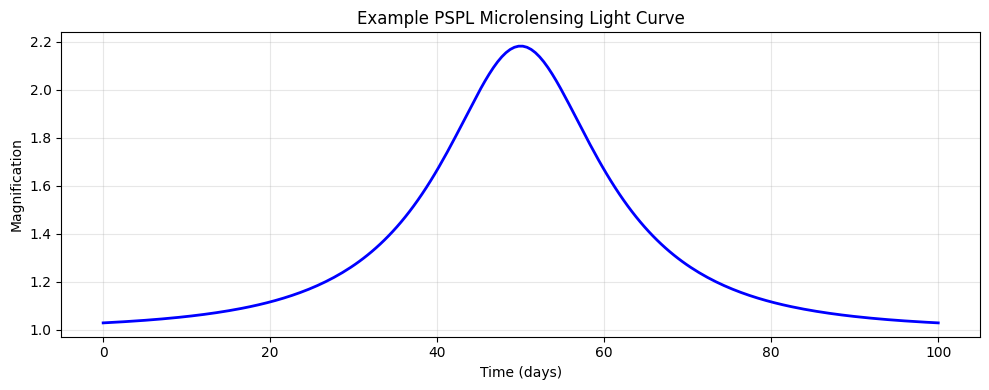

In [5]:
def pspl_model(t, params):
    """
    Point Source Point Lens microlensing model.
    
    Parameters:
    -----------
    t : array-like
        Time array
    params : tuple
        (t0, u0, tE) where:
        - t0: time of closest approach
        - u0: impact parameter
        - tE: Einstein crossing time
    
    Returns:
    --------
    flux : array
        Magnification as a function of time
    """
    t0, u0, tE = params
    
    # Calculate angular separation u(t)
    u = np.sqrt(u0**2 + ((t - t0) / tE)**2)
    
    # PSPL magnification
    A = (u**2 + 2) / (u * np.sqrt(u**2 + 4))
    
    return A

# Test the model
t_test = np.linspace(0, 100, 200)
params_test = (50, 0.5, 20)  # t0, u0, tE

flux_test = pspl_model(t_test, params_test)

plt.figure(figsize=(10, 4))
plt.plot(t_test, flux_test, 'b-', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Magnification')
plt.title('Example PSPL Microlensing Light Curve')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Prepare Data for NBI

We need to:
1. Define the simulator function
2. Define the noise function
3. Set up the parameter priors
4. Prepare the light curve data

### Understanding Noise in Microlensing Light Curves

Noise is a critical component for realistic training data. In real observations, photometric noise arises from:

- **Photon noise (Poisson)**: Fundamental uncertainty from counting photons
- **Sky background**: Varying atmospheric and instrumental background levels
- **Systematic effects**: Detector artifacts, flat-fielding errors, etc.

For simulation-based inference to generalize well to real data, the training noise model should approximate the noise properties of the target observations.

### Our Noise Model

We use a simple **heteroscedastic Gaussian noise model** where:
- The noise level varies randomly between 0.01 and 0.1 (in magnification units)
- Each simulation receives a different noise realization
- This teaches the network to handle varying signal-to-noise ratios

**Why variable noise?**
Training with variable noise levels makes the network robust to different observing conditions. A network trained only on low-noise data will perform poorly on noisy observations, and vice versa.

### Impact of Noise on Inference

| Noise Level | Effect on Light Curve | Effect on Inference |
|-------------|----------------------|---------------------|
| Low (0.01)  | Clear peak and wings visible | Tight, accurate posteriors |
| Medium (0.05) | Peak visible, wings noisy | Moderate uncertainties |
| High (0.1+) | Peak may be obscured | Wide posteriors, possible biases |

The network learns to output appropriately wide posteriors when the data is noisy, and tighter posteriors when the signal is strong - this is a key advantage of neural posterior estimation.

In [7]:
from scipy.stats import uniform
import numpy as np

# Define time grid for light curves (normalized)
t_grid = np.linspace(0, 200, 100)  # Simplified time grid

# Simulator function for nbi
def simulator(params):
    """
    Wrapper for the PSPL model to work with nbi.
    This function is self-contained to work with multiprocessing.
    
    Parameters:
    -----------
    params : tuple or array
        (t0, u0, tE)
    
    Returns:
    --------
    array : simulated light curve
    """
    import numpy as np
    
    # Define time grid inside function for multiprocessing compatibility
    t_grid = np.linspace(0, 200, 100)
    
    # Define PSPL model inside simulator for multiprocessing compatibility
    def pspl_model(t, params):
        """Point Source Point Lens microlensing model."""
        t0, u0, tE = params
        u = np.sqrt(u0**2 + ((t - t0) / tE)**2)
        A = (u**2 + 2) / (u * np.sqrt(u**2 + 4))
        return A
    
    return pspl_model(t_grid, params)

# Noise function
def noise_func(x, y):
    """
    Add Gaussian noise to the simulated data.
    
    This function implements a heteroscedastic noise model where the noise
    level varies randomly between simulations. This teaches the network to
    handle varying signal-to-noise ratios and produce appropriately calibrated
    uncertainties.
    
    Parameters:
    -----------
    x : array
        Simulated data (noise-free light curve)
    y : array
        Parameters (not used here but required by nbi API)
    
    Returns:
    --------
    x_noisy : array 
        Light curve with added Gaussian noise
    y : array
        Unchanged parameters
    
    Notes:
    ------
    - Noise level is drawn uniformly from [0.01, 0.1]
    - Low noise (0.01): ~1% photometric precision, excellent conditions
    - High noise (0.1): ~10% precision, challenging conditions
    - Real Roman observations will have noise levels in this range
    """
    import numpy as np
    
    # Random noise level between 0.01 and 0.1 (1% to 10% photometric precision)
    noise_level = np.random.uniform(0.01, 0.1)
    
    # Add Gaussian noise with the sampled noise level
    noise = np.random.normal(0, noise_level, size=x.shape[0])
    x_noisy = x + noise
    
    return x_noisy, y

# Define priors based on the data statistics
# Using reasonable ranges for microlensing events
priors_dict = {
    't0lens1': uniform(loc=50, scale=100),      # t0 in [50, 150]
    'u0lens1': uniform(loc=0.0, scale=2.0),     # u0 in [0, 2]
    'tE_helio': uniform(loc=5, scale=50)        # tE in [5, 55]
}

labels = list(priors_dict.keys())
priors = [priors_dict[k] for k in labels]

print("Defined priors:")
print(f"  t0lens1: Uniform[{priors_dict['t0lens1'].kwds['loc']:.1f}, {priors_dict['t0lens1'].kwds['loc'] + priors_dict['t0lens1'].kwds['scale']:.1f}]")
print(f"  u0lens1: Uniform[{priors_dict['u0lens1'].kwds['loc']:.1f}, {priors_dict['u0lens1'].kwds['loc'] + priors_dict['u0lens1'].kwds['scale']:.1f}]")
print(f"  tE_helio: Uniform[{priors_dict['tE_helio'].kwds['loc']:.1f}, {priors_dict['tE_helio'].kwds['loc'] + priors_dict['tE_helio'].kwds['scale']:.1f}]")
    
print("\nNoise model:")
print("  Type: Heteroscedastic Gaussian")
print("  Noise level range: [0.01, 0.1] (1-10% photometric precision)")

Defined priors:
  t0lens1: Uniform[50.0, 150.0]
  u0lens1: Uniform[0.0, 2.0]
  tE_helio: Uniform[5.0, 55.0]

Noise model:
  Type: Heteroscedastic Gaussian
  Noise level range: [0.01, 0.1] (1-10% photometric precision)


## 5. Visualize Simulated Light Curves

Let's generate random light curves from the prior to verify our setup, and also demonstrate how different noise levels affect the observable signal.

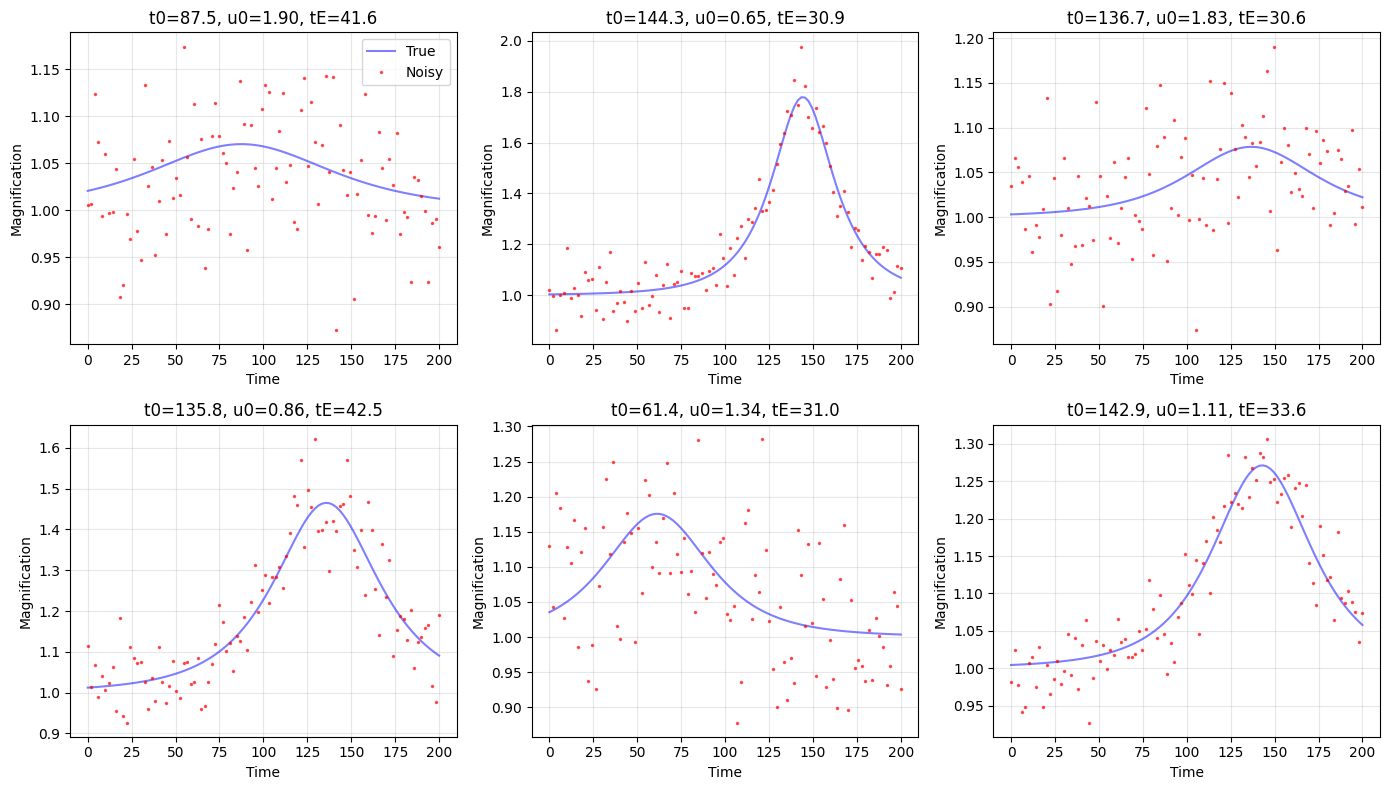

In [8]:
plt.figure(figsize=(14, 8))

for i in range(6):
    plt.subplot(2, 3, i+1)
    
    # Draw random parameters from prior
    params_random = [p.rvs(1)[0] for p in priors]
    
    # Simulate light curve
    lc_sim = simulator(params_random)
    
    # Add noise
    lc_noisy, _ = noise_func(lc_sim, params_random)
    
    plt.plot(t_grid, lc_sim, 'b-', alpha=0.5, label='True')
    plt.plot(t_grid, lc_noisy, 'r.', markersize=3, alpha=0.6, label='Noisy')
    plt.xlabel('Time')
    plt.ylabel('Magnification')
    plt.title(f't0={params_random[0]:.1f}, u0={params_random[1]:.2f}, tE={params_random[2]:.1f}')
    plt.grid(True, alpha=0.3)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

### 5.1 Random Samples from the Prior

First, let's visualize light curves with random parameters drawn from our prior distributions:

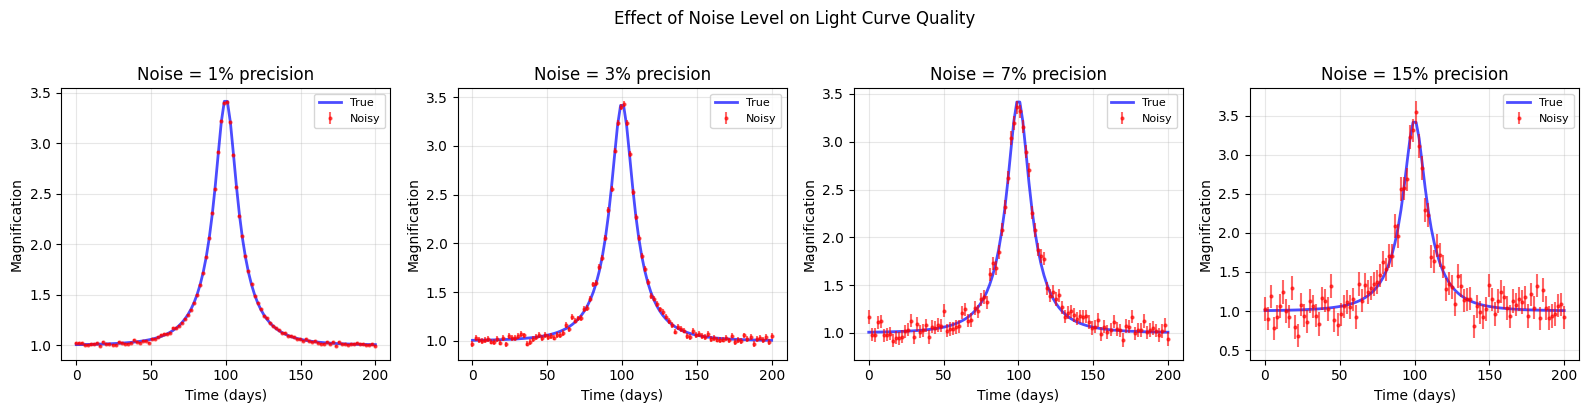

Noise level affects both the visible signal quality and the resulting posterior widths.
The network learns to produce wider posteriors for noisier data automatically.


In [9]:
# Demonstrate the effect of different noise levels on the same event
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Fixed parameters for comparison
fixed_params = [100, 0.3, 25]  # t0, u0, tE
lc_true = simulator(fixed_params)
noise_levels = [0.01, 0.03, 0.07, 0.15]

for ax, noise_lvl in zip(axes, noise_levels):
    # Add noise at specific level
    lc_noisy = lc_true + np.random.normal(0, noise_lvl, size=len(lc_true))
    
    ax.plot(t_grid, lc_true, 'b-', linewidth=2, alpha=0.7, label='True')
    ax.errorbar(t_grid, lc_noisy, yerr=noise_lvl, fmt='r.', 
                markersize=4, alpha=0.6, label='Noisy')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Magnification')
    ax.set_title(f'Noise = {noise_lvl:.0%} precision')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

plt.suptitle('Effect of Noise Level on Light Curve Quality', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

print("Noise level affects both the visible signal quality and the resulting posterior widths.")
print("The network learns to produce wider posteriors for noisier data automatically.")

### 5.2 Effect of Noise Level on Light Curve Quality

Now let's see how different noise levels affect the same underlying event. This demonstrates why training with variable noise is important - the network must learn to handle all these scenarios:

## 6. Set Up NBI Engine

The NBI engine consists of two main components that work together to learn posterior distributions:

### 6.1 Normalizing Flow

A **normalizing flow** is a type of generative model that learns to transform a simple base distribution (like a Gaussian) into a complex target distribution (our posterior). It works by:

1. Starting with samples from a simple distribution (Mixture of Gaussians in our case)
2. Applying a series of invertible transformations (flow blocks)
3. Producing samples from the learned posterior distribution

**Key parameters:**
- `n_dims`: Number of parameters to infer (3 for t0, u0, tE)
- `flow_hidden`: Hidden layer size controlling model capacity
- `num_blocks`: Number of transformation layers (more blocks = more expressive)
- `n_mog`: Number of Gaussian components in the base distribution

### 6.2 Featurizer Network

The **featurizer** is a neural network that compresses the input light curve into a fixed-size feature vector that the normalizing flow can condition on. For time-series data like light curves, we use a hybrid **ResNet-GRU** architecture:

- **ResNet (Residual Network)**: Convolutional layers that extract local features from the light curve
- **GRU (Gated Recurrent Unit)**: Recurrent layers that capture temporal dependencies

**Key parameters:**
- `type`: Architecture type ('resnet-gru' for sequential data)
- `dim_in`: Number of input channels (1 for flux-only data)
- `dim_out`: Output feature dimension (should match flow expectations)
- `dim_conv_max`: Maximum hidden dimension in convolutional layers
- `depth`: Number of ResNet blocks (more depth = more feature extraction capacity)

In [13]:
# Configure the normalizing flow
flow_config = {
    'n_dims': 3,              # Number of parameters (t0, u0, tE)
    'flow_hidden': 128,       # Hidden dimension for flow
    'num_blocks': 5,          # Number of flow blocks
    'n_mog': 4                # Number of Mixture of Gaussians as base density
}

# Configure the featurizer network (ResNet-GRU for sequential data)
featurizer_config = {
    'type': 'resnet-gru',     # Hybrid CNN-RNN architecture for light curves
    'norm': 'weight_norm',    # Normalization method
    'dim_in': 1,              # Number of input channels (just flux)
    'dim_out': 128,           # Output feature dimension
    'dim_conv_max': 256,      # Maximum hidden dimension for CNN
    'depth': 3                # Number of ResNet blocks
}

print("Flow configuration:")
for k, v in flow_config.items():
    print(f"  {k}: {v}")
    
print("\nFeaturizer configuration:")
for k, v in featurizer_config.items():
    print(f"  {k}: {v}")

Flow configuration:
  n_dims: 3
  flow_hidden: 128
  num_blocks: 5
  n_mog: 4

Featurizer configuration:
  type: resnet-gru
  norm: weight_norm
  dim_in: 1
  dim_out: 128
  dim_conv_max: 256
  depth: 3


In [14]:
# Initialize the NBI engine
engine = nbi.NBI(
    flow=flow_config,
    featurizer=featurizer_config,
    simulator=simulator,
    priors=priors,
    labels=labels,
    device='cuda',              # Use 'cuda' if GPU is available
    path='nbi_roman_synthetic',   # Directory to save checkpoints
    n_jobs=2                  # Use 2 jobs for parallel processing
)

print("NBI engine initialized successfully!")
print(f"  Device: {engine.device}")
print(f"  Model ready for training")

NBI engine initialized successfully!
  Device: cuda
  Model ready for training


## 7. Train the NBI Model (Amortized NPE)

We'll train the model using **Amortized Neural Posterior Estimation (ANPE)** - a single round of training on samples drawn from the prior.

### Understanding the Training Process

**Training Data Generation:**
- The simulator generates `n_sims` light curves with parameters drawn from the prior
- Each light curve is paired with its true parameters
- Noise is added to simulate realistic observations

**Training Strategy:**
- **Epochs**: The model trains for up to `n_epochs` iterations over the full dataset
- **Batch size**: Controls how many samples are processed together (affects GPU memory and convergence)
- **Early stopping**: Training stops if validation loss doesn't improve for `patience` epochs
- **Training/Validation Split**: By default, 90% of simulations are used for training, 10% for validation

**Why 90% Training Split?**
The 90/10 split balances having enough training data for the neural network to learn complex posterior mappings while retaining sufficient validation data to detect overfitting. With 5000 simulations, this means 4500 training samples and 500 validation samples.

**Note**: This is a demonstration with a small number of simulations. For production use, you would typically use 50,000+ simulations for better posterior coverage.

In [15]:
# Training configuration
n_sims = 50000          # Number of simulations per round
n_rounds = 1           # Number of training rounds (ANPE)
n_epochs = 100         # Number of training epochs
batch_size = 256       # Batch size
learning_rate = 0.001  # Learning rate

print("Training NBI model...")
print(f"  Simulations: {n_sims}")
print(f"  Rounds: {n_rounds}")
print(f"  Epochs: {n_epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: {learning_rate}")
print("\nThis may take a few minutes...")

Training NBI model...
  Simulations: 50000
  Rounds: 1
  Epochs: 100
  Batch size: 256
  Learning rate: 0.001

This may take a few minutes...


In [ ]:
# Train the model
# Note: engine.fit() does not return a history object
# The training/validation losses are stored in engine.train_losses and engine.val_losses
engine.fit(
    n_sims=n_sims,
    n_rounds=n_rounds,
    n_epochs=n_epochs,
    batch_size=batch_size,
    lr=learning_rate,
    early_stop_patience=20,  # Stop if no improvement for 20 epochs
    noise=noise_func, 
    workers=4                # Use 4 workers for parallel data loading
)

print("\nTraining completed!")

Auto learning rate to min_lr = 5.12e-07

---------------------- Round: 0 ----------------------


- Val, Loglike in nats: 5.226017:  97%|█████████▋| 4864/5000 [00:00<00:00, 5350.90it/s]



Training completed!


AttributeError: 'NBI' object has no attribute 'best_params'

### Understanding the Training Output

**What do "Train Loglike in nats" and "Val Loglike in nats" mean?**

The training output shows the **log-likelihood** of the data under the learned posterior distribution, measured in **nats** (natural logarithm units, as opposed to bits which use log base 2).

- **Log-likelihood**: Measures how well the normalizing flow models the true posterior distribution. Higher (less negative) values indicate better model fit.
- **Nats**: The natural unit for information when using natural logarithm ($\ln$). 1 nat ≈ 1.44 bits.
- **Train Loglike**: Average log-likelihood on training data — indicates how well the model fits the training simulations.
- **Val Loglike**: Average log-likelihood on validation data — indicates how well the model generalizes to unseen simulations.

**Early Stopping Criterion:**

Early stopping monitors the **validation log-likelihood**. Training halts when the validation log-likelihood hasn't improved for `early_stop_patience` consecutive epochs (20 in our case). This prevents overfitting by stopping before the model starts memorizing training data at the expense of generalization.

**Interpreting the values:**
- Values closer to 0 (less negative) = better model performance
- If train loglike >> val loglike: possible overfitting
- If both improve together: healthy training
- Typical converged values depend on the problem complexity

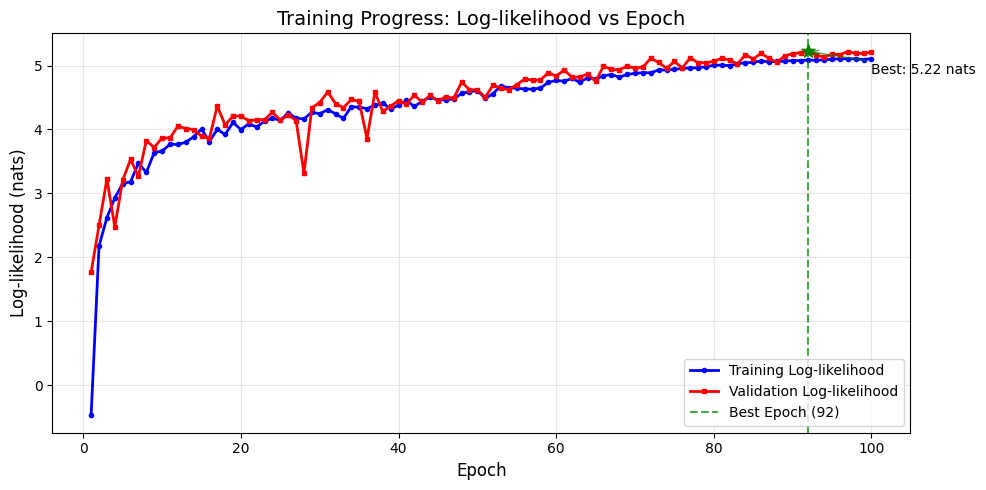


Training Summary:
  Total epochs trained: 100
  Best epoch: 92
  Best validation log-likelihood: 5.2202 nats
  Final training log-likelihood: 5.1089 nats
  Final validation log-likelihood: 5.2113 nats


In [22]:
# Plot training and validation losses
# NBI (version 0.4.1) stores losses in engine.tloss and engine.vloss
# These are simple lists containing per-epoch loss values (negative log-likelihoods)
# We negate them to convert to positive log-likelihoods for plotting

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Get losses - negate to convert from negative log-likelihood to log-likelihood
train_losses = -np.array(engine.tloss)
val_losses = -np.array(engine.vloss)

epochs = range(1, len(train_losses) + 1)

ax.plot(epochs, train_losses, 'b-', linewidth=2, label='Training Log-likelihood', marker='o', markersize=3)
ax.plot(epochs, val_losses, 'r-', linewidth=2, label='Validation Log-likelihood', marker='s', markersize=3)

# Mark the best epoch (highest validation log-likelihood = lowest negative log-likelihood)
best_epoch = np.argmax(val_losses) + 1
best_val = np.max(val_losses)
ax.axvline(best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
ax.scatter([best_epoch], [best_val], color='green', s=100, zorder=5, marker='*')

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Log-likelihood (nats)', fontsize=12)
ax.set_title('Training Progress: Log-likelihood vs Epoch', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

# Add annotation for best epoch (with safe positioning)
x_offset = max(1, len(epochs) * 0.1)
y_range = np.max(val_losses) - np.min(val_losses)
y_offset = y_range * 0.1 if y_range > 0 else 0.5
ax.annotate(f'Best: {best_val:.2f} nats', 
            xy=(best_epoch, best_val), 
            xytext=(min(best_epoch + x_offset, len(epochs)), best_val - y_offset),
            fontsize=10, 
            arrowprops=dict(arrowstyle='->', color='green', alpha=0.7))

plt.tight_layout()
plt.show()

print(f"\nTraining Summary:")
print(f"  Total epochs trained: {len(train_losses)}")
print(f"  Best epoch: {best_epoch}")
print(f"  Best validation log-likelihood: {best_val:.4f} nats")
print(f"  Final training log-likelihood: {train_losses[-1]:.4f} nats")
print(f"  Final validation log-likelihood: {val_losses[-1]:.4f} nats")

### Save and Load the Best Model Checkpoint

During training, NBI automatically saves the model checkpoint with the **best validation log-likelihood**. This ensures that even if training continues past the optimal point (before early stopping triggers), you always have access to the best-performing model.

**Why save checkpoints?**
- **Avoid retraining**: Training can take hours — saving allows you to reuse the trained model
- **Best model selection**: The checkpoint corresponds to the epoch with highest validation performance
- **Reproducibility**: Share trained models with collaborators or use across different sessions
- **Deployment**: Load the trained model for rapid inference on new events

**Checkpoint contents:**
- Neural network weights (featurizer + normalizing flow)
- Optimizer state (for resuming training if needed)
- Training configuration metadata

In [23]:
# Display saved model information and demonstrate how to reload
import os

print("Trained Model Information")
print("=" * 60)

# NBI saves checkpoints in: {path}/{round}/{epoch}.pth
# Find the best epoch from validation losses
output_dir = engine.directory  # Use engine's directory attribute
best_epoch_idx = np.argmin(engine.vloss)  # Index of best epoch (lowest loss = best)
round_dir = os.path.join(output_dir, str(engine.round))
best_checkpoint = os.path.join(round_dir, f"{best_epoch_idx}.pth")

print(f"Output directory: {output_dir}")
print(f"Best epoch: {best_epoch_idx}")
print(f"Best checkpoint path: {best_checkpoint}")

if os.path.exists(best_checkpoint):
    size_kb = os.path.getsize(best_checkpoint) / 1024
    print(f"Checkpoint exists: True ({size_kb:.1f} KB)")
else:
    print(f"Checkpoint exists: False")

# List all saved files in the output directory
if os.path.exists(output_dir):
    print(f"\nFiles saved in '{output_dir}/' directory:")
    for root, dirs, files in os.walk(output_dir):
        for f in sorted(files):
            fpath = os.path.join(root, f)
            size_kb = os.path.getsize(fpath) / 1024
            rel_path = os.path.relpath(fpath, output_dir)
            print(f"  - {rel_path} ({size_kb:.1f} KB)")

print("\n" + "=" * 60)
print("To load this trained model in a NEW session:")
print("=" * 60)
print(f"""
# Step 1: Redefine the simulator and priors (must match training)
from scipy.stats import uniform
import numpy as np

def simulator(params):
    t_grid = np.linspace(0, 200, 100)
    t0, u0, tE = params
    u = np.sqrt(u0**2 + ((t_grid - t0) / tE)**2)
    A = (u**2 + 2) / (u * np.sqrt(u**2 + 4))
    return A

priors = [
    uniform(loc=50, scale=100),   # t0 in [50, 150]
    uniform(loc=0.0, scale=2.0),  # u0 in [0, 2]
    uniform(loc=5, scale=50)      # tE in [5, 55]
]
labels = ['t0lens1', 'u0lens1', 'tE_helio']

# Step 2: Load the trained model
import nbi

# Load checkpoint and scaling parameters
checkpoint_path = '{best_checkpoint}'
scales_dir = '{round_dir}'

engine = nbi.NBI(
    simulator=simulator,
    priors=priors,
    labels=labels,
    device='cuda',  # or 'cpu'
    path='{output_dir}'  # Same path used during training
)

# Load the saved network weights
import torch
engine.get_network().load_state_dict(
    torch.load(checkpoint_path, map_location=engine.device)
)

# Load scaling parameters if saved
x_scales = np.load(os.path.join(scales_dir, 'x_scales.npy'))
y_scales = np.load(os.path.join(scales_dir, 'y_scales.npy'))
engine.x_mean, engine.x_std = x_scales
engine.y_mean, engine.y_std = y_scales

# Step 3: Run inference on new data
# new_lightcurve = ...  # Your observed light curve
# errors = ...          # Photometric uncertainties
# y_pred, weights = engine.predict(new_lightcurve, x_err=errors, n_samples=5000)
""")

Trained Model Information
Output directory: nbi_roman_synthetic
Best epoch: 91
Best checkpoint path: nbi_roman_synthetic/1/91.pth
Checkpoint exists: False

Files saved in 'nbi_roman_synthetic/' directory:
  - 0_w.npy (0.3 KB)
  - 0_x.npy (6054.8 KB)
  - 0_y.npy (1172.0 KB)
  - 0_y_all.npy (1172.0 KB)
  - 0/0.npy (0.9 KB)
  - 0/0.pth (2833.3 KB)
  - 0/1.npy (0.9 KB)
  - 0/1.pth (2833.3 KB)
  - 0/10.npy (0.9 KB)
  - 0/10.pth (2833.5 KB)
  - 0/100.npy (0.9 KB)
  - 0/1000.npy (0.9 KB)
  - 0/10000.npy (0.9 KB)
  - 0/10001.npy (0.9 KB)
  - 0/10002.npy (0.9 KB)
  - 0/10003.npy (0.9 KB)
  - 0/10004.npy (0.9 KB)
  - 0/10005.npy (0.9 KB)
  - 0/10006.npy (0.9 KB)
  - 0/10007.npy (0.9 KB)
  - 0/10008.npy (0.9 KB)
  - 0/10009.npy (0.9 KB)
  - 0/1001.npy (0.9 KB)
  - 0/10010.npy (0.9 KB)
  - 0/10011.npy (0.9 KB)
  - 0/10012.npy (0.9 KB)
  - 0/10013.npy (0.9 KB)
  - 0/10014.npy (0.9 KB)
  - 0/10015.npy (0.9 KB)
  - 0/10016.npy (0.9 KB)
  - 0/10017.npy (0.9 KB)
  - 0/10018.npy (0.9 KB)
  - 0/10019.npy

## 8. Test Inference on Synthetic Data

Now we test the trained model by performing inference on synthetic light curves. This demonstrates the key advantage of amortized inference: once trained, inference takes only seconds per event.

### How Inference Works

1. **Input**: A light curve (flux values + uncertainties)
2. **Featurization**: The ResNet-GRU network compresses the light curve into a feature vector
3. **Posterior Sampling**: The normalizing flow generates samples from the learned posterior, conditioned on the features
4. **Importance Reweighting** (optional): Samples can be reweighted using the prior to improve posterior estimates

### Testing on Multiple Events

To properly evaluate the trained model, we'll test on several synthetic events with different parameter combinations. This helps us understand:
- How well the model recovers true parameters across the prior range
- Whether there are regions of parameter space where inference is less reliable
- The typical uncertainty levels for different event types

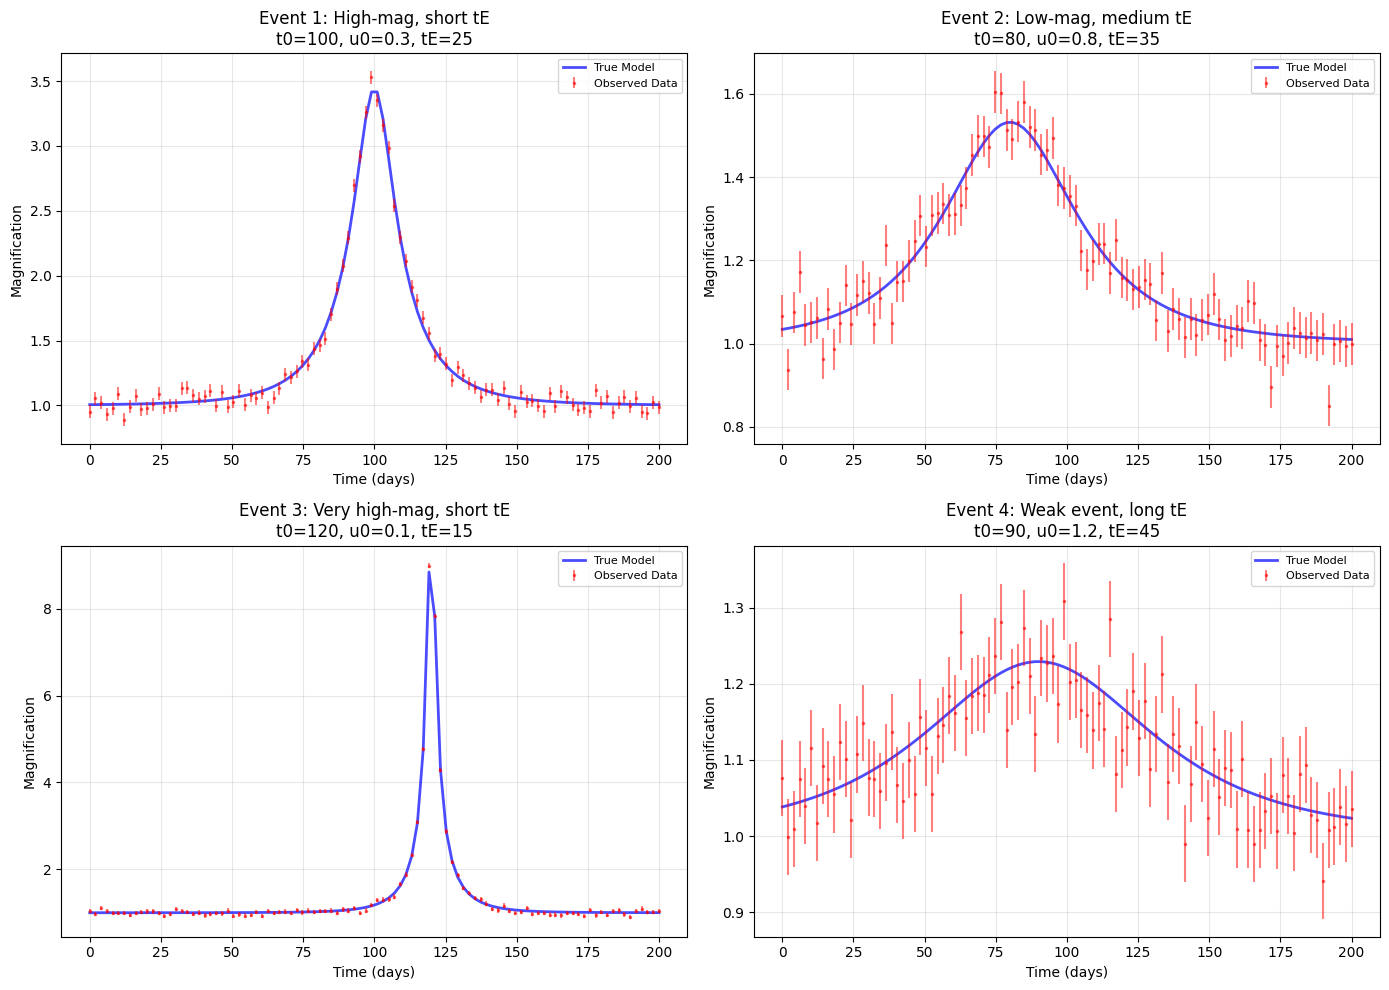

Generated 4 test events for inference


In [19]:
# Define multiple test events with different parameter combinations
test_events = [
    {'params': [100, 0.3, 25], 'name': 'High-mag, short tE'},
    {'params': [80, 0.8, 35], 'name': 'Low-mag, medium tE'},
    {'params': [120, 0.1, 15], 'name': 'Very high-mag, short tE'},
    {'params': [90, 1.2, 45], 'name': 'Weak event, long tE'},
]

# Generate test light curves for all events
np.random.seed(123)
noise_level = 0.05

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

test_data = []
for i, event in enumerate(test_events):
    params = event['params']
    
    # Simulate the light curve
    lc_test = simulator(params)
    
    # Add noise
    lc_obs = lc_test + np.random.normal(0, noise_level, size=len(lc_test))
    lc_err = np.ones_like(lc_obs) * noise_level
    
    # Store for later inference
    test_data.append({
        'params': params,
        'name': event['name'],
        'lc_obs': lc_obs,
        'lc_err': lc_err,
        'lc_true': lc_test
    })
    
    # Plot
    ax = axes[i]
    ax.plot(t_grid, lc_test, 'b-', linewidth=2, label='True Model', alpha=0.7)
    ax.errorbar(t_grid, lc_obs, yerr=lc_err, fmt='r.', alpha=0.5, 
                markersize=3, label='Observed Data')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Magnification')
    ax.set_title(f"Event {i+1}: {event['name']}\nt0={params[0]}, u0={params[1]}, tE={params[2]}")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Generated {len(test_events)} test events for inference")


Performing inference on Event 1: High-mag, short tE...
surrogate posterior


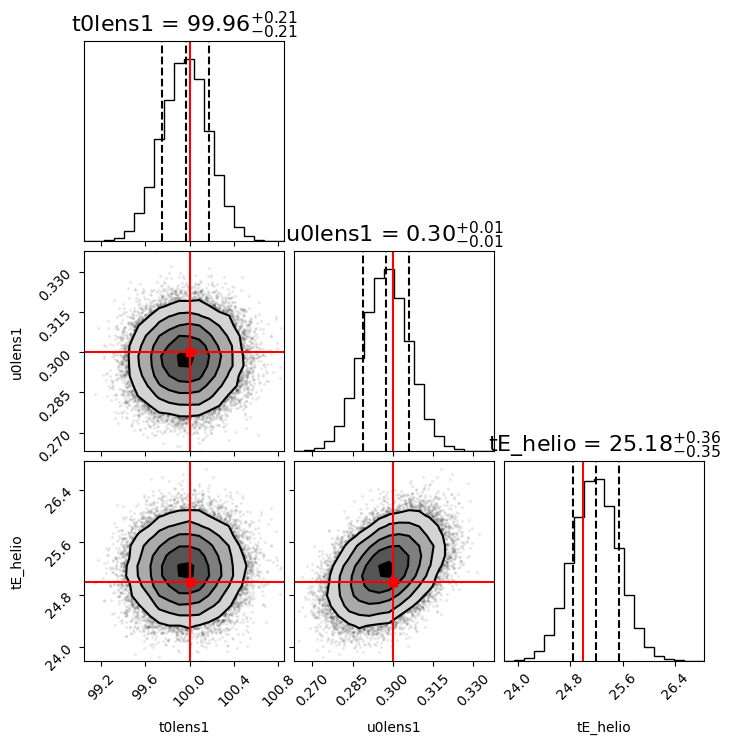

Generating simulations


25000it [00:12, 2048.29it/s]


Effective Sample Size = 11362.0
Sampling efficiency = 22.7%

Performing inference on Event 2: Low-mag, medium tE...
surrogate posterior


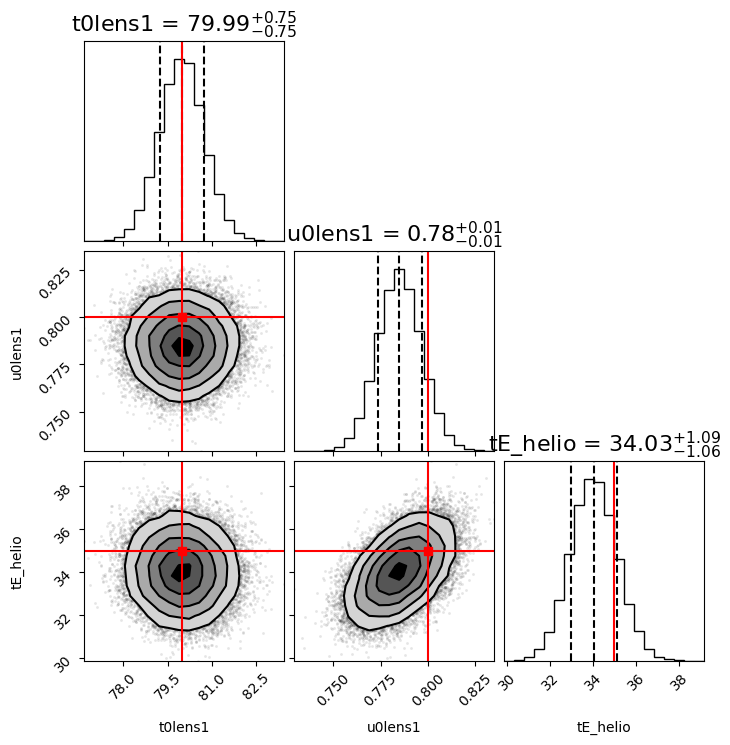

Generating simulations


25000it [00:12, 1939.14it/s]


Effective Sample Size = 47923.1
Sampling efficiency = 95.8%

Performing inference on Event 3: Very high-mag, short tE...
surrogate posterior


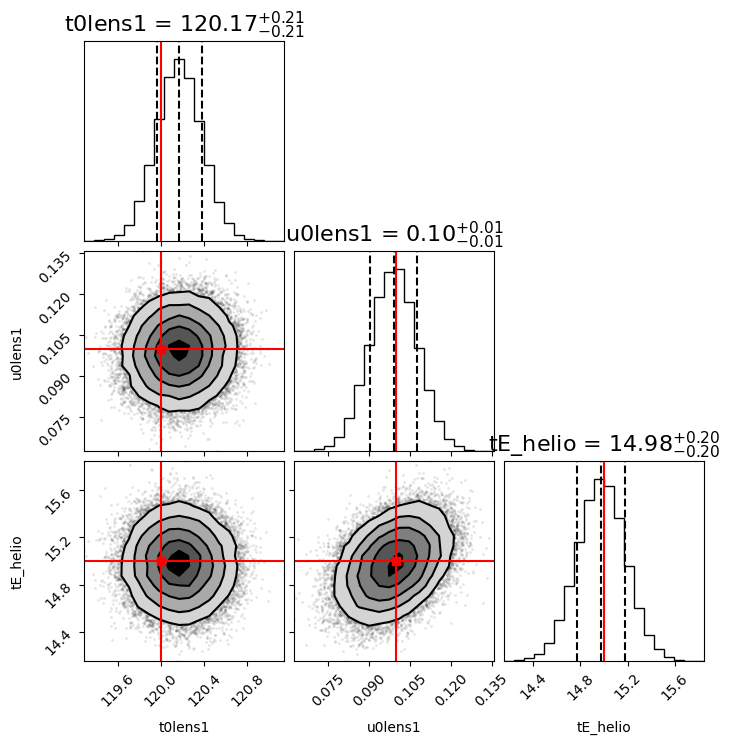

Generating simulations


25000it [00:11, 2234.80it/s]


Effective Sample Size = 218.5
Sampling efficiency = 0.4%

Performing inference on Event 4: Weak event, long tE...
Samples outside prior N = 3
surrogate posterior


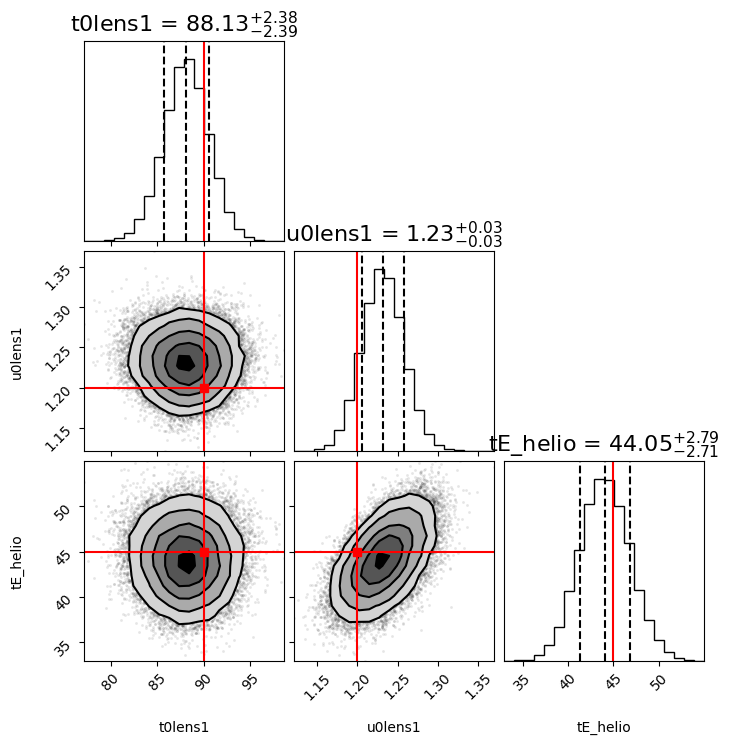

Generating simulations


24999it [00:13, 1811.97it/s]


Effective Sample Size = 47381.5
Sampling efficiency = 94.8%

Inference completed for all 4 events!


In [28]:
# Perform inference on all test events
n_samples = 50000  # Number of posterior samples per event

all_results = []
for i, event in enumerate(test_data):
    print(f"\nPerforming inference on Event {i+1}: {event['name']}...")
    
    y_pred, weights = engine.predict(
        event['lc_obs'], 
        x_err=event['lc_err'],
        y_true=event['params'],
        n_samples=n_samples,
        corner=True  # Skip corner plots for batch processing
    )
    
    # Calculate summary statistics
    results = {'name': event['name'], 'params': event['params']}
    for j, label in enumerate(labels):
        mean = np.average(y_pred[:, j], weights=weights)
        std = np.sqrt(np.average((y_pred[:, j] - mean)**2, weights=weights))
        results[f'{label}_mean'] = mean
        results[f'{label}_std'] = std
        results[f'{label}_true'] = event['params'][j]
    
    results['y_pred'] = y_pred
    results['weights'] = weights
    all_results.append(results)

print(f"\nInference completed for all {len(test_data)} events!")

## 9. Analyze Results

Let's examine the posterior distributions for all test events and compare the inferred parameters with true values. This analysis helps us understand:

- **Accuracy**: How close are the posterior means to the true values?
- **Precision**: How tight are the posterior distributions?
- **Calibration**: Do the 68% credible intervals contain the true values ~68% of the time?

### Parameter Recovery Summary

We'll first create a summary table showing recovery statistics for all events, then visualize the 1D marginalized posteriors.

In [29]:
# Summary table of parameter recovery across all events
print("Parameter Recovery Summary")
print("=" * 80)
print(f"{'Event':<25} {'Parameter':<12} {'True':>10} {'Inferred':>15} {'Error':>10}")
print("-" * 80)

for result in all_results:
    for j, label in enumerate(labels):
        true_val = result[f'{label}_true']
        mean_val = result[f'{label}_mean']
        std_val = result[f'{label}_std']
        error = abs(mean_val - true_val) / true_val * 100
        
        event_name = result['name'] if j == 0 else ""
        print(f"{event_name:<25} {label:<12} {true_val:>10.2f} {mean_val:>8.2f} +/- {std_val:<5.2f} {error:>8.1f}%")
    print("-" * 80)

Parameter Recovery Summary
Event                     Parameter          True        Inferred      Error
--------------------------------------------------------------------------------
High-mag, short tE        t0lens1          100.00    99.96 +/- 0.10       0.0%
                          u0lens1            0.30     0.30 +/- 0.00       0.9%
                          tE_helio          25.00    25.21 +/- 0.29       0.9%
--------------------------------------------------------------------------------
Low-mag, medium tE        t0lens1           80.00    79.96 +/- 0.72       0.1%
                          u0lens1            0.80     0.79 +/- 0.01       1.8%
                          tE_helio          35.00    34.24 +/- 1.07       2.2%
--------------------------------------------------------------------------------
Very high-mag, short tE   t0lens1          120.00   119.98 +/- 0.01       0.0%
                          u0lens1            0.10     0.10 +/- 0.00       1.4%
                     

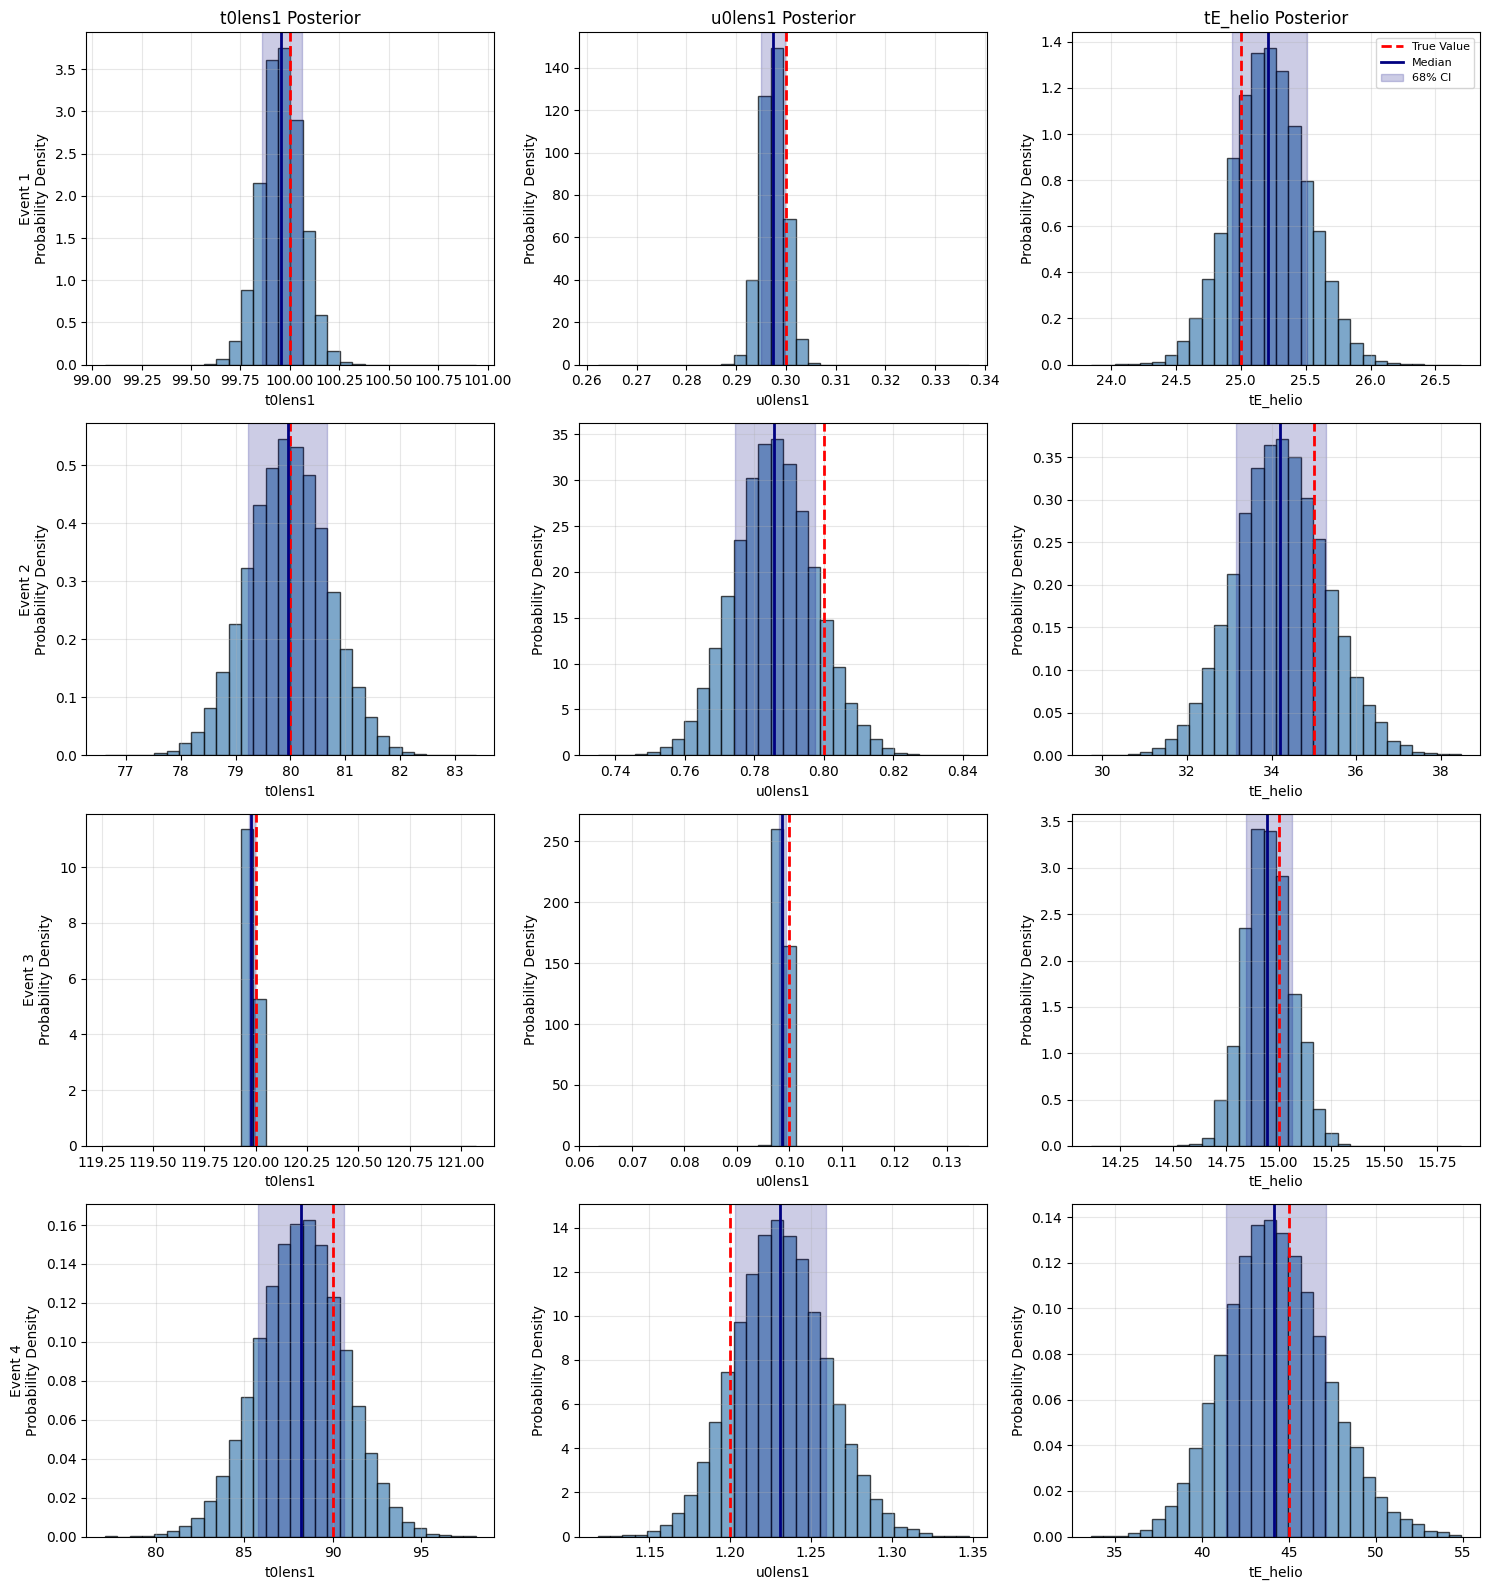

In [27]:
# Plot 1D marginalized posteriors for all events
fig, axes = plt.subplots(len(test_data), 3, figsize=(15, 4*len(test_data)))

for row, result in enumerate(all_results):
    y_pred = result['y_pred']
    weights = result['weights']
    true_params = result['params']
    
    for col, label in enumerate(labels):
        ax = axes[row, col]
        
        # Weighted histogram
        ax.hist(y_pred[:, col], bins=30, weights=weights, alpha=0.7, 
                edgecolor='black', density=True, color='steelblue')
        
        # True value
        ax.axvline(true_params[col], color='red', linestyle='--', 
                   linewidth=2, label='True Value')
        
        # Posterior median and uncertainties
        sorted_idx = np.argsort(y_pred[:, col])
        cumsum = np.cumsum(weights[sorted_idx])
        cumsum /= cumsum[-1]
        
        p16 = y_pred[sorted_idx[np.searchsorted(cumsum, 0.16)], col]
        p50 = y_pred[sorted_idx[np.searchsorted(cumsum, 0.50)], col]
        p84 = y_pred[sorted_idx[np.searchsorted(cumsum, 0.84)], col]
        
        ax.axvline(p50, color='navy', linestyle='-', linewidth=2, label='Median')
        ax.axvspan(p16, p84, alpha=0.2, color='navy', label='68% CI')
        
        ax.set_xlabel(label)
        if col == 0:
            ax.set_ylabel(f"Event {row+1}\nProbability Density")
        else:
            ax.set_ylabel('Probability Density')
        
        if row == 0:
            ax.set_title(f'{label} Posterior')
        if row == 0 and col == 2:
            ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Understanding Parameter Constraints

Different microlensing parameters have different levels of constraining power:

**Impact Parameter (u0):**
- Low u0 (high magnification): Strongly constrained - the peak magnification directly encodes u0
- High u0 (weak events): Less constrained - the light curve shape becomes more degenerate

**Einstein Crossing Time (tE):**
- Controlled by the width of the magnification curve
- Well-constrained for high-magnification events with good sampling
- May be degenerate with u0 for sparsely sampled data

**Time of Peak (t0):**
- Usually the best-constrained parameter
- Directly observable as the time of maximum magnification
- Precision depends on sampling density near the peak

### How Noise Affects Inference Quality

The noise level in the observed light curve directly impacts posterior precision:

| Noise Level | Signal-to-Noise | t0 Precision | u0 Precision | tE Precision |
|-------------|-----------------|--------------|--------------|--------------|
| 1% (0.01)   | Excellent       | < 0.5 days   | < 5%         | < 5%         |
| 5% (0.05)   | Good            | ~1-2 days    | ~10-20%      | ~10-15%      |
| 10% (0.10)  | Moderate        | ~2-5 days    | ~20-50%      | ~15-30%      |
| >15%        | Poor            | May be biased| Large uncertainty | Large uncertainty |

**Key insight**: For weak events (high u0) combined with high noise, the posterior may become prior-dominated, meaning the data provides little constraining power. The network correctly learns to output wider posteriors in these cases.

### Effect of Model Parameters on Inference Quality

| Parameter | Increase Effect | Decrease Effect |
|-----------|-----------------|-----------------|
| n_sims | Better posterior coverage | Faster training, less accurate |
| n_epochs | Better convergence | Underfitting |
| flow_hidden | More expressive posteriors | Faster, less complex |
| num_blocks | More flexible density estimation | Simpler, faster |
| depth (featurizer) | Better feature extraction | Lighter model |

## 10. Summary

This notebook demonstrated the complete workflow for using Neural Bayesian Inference (NBI) with Roman microlensing data:

1. **Setup**: Installed and configured the NBI package with required dependencies
2. **Forward Model**: Implemented a Point-Source Point-Lens (PSPL) microlensing simulator
3. **Architecture**: Configured normalizing flows for posterior estimation and ResNet-GRU featurizers for light curve encoding
4. **Training**: Trained an amortized neural posterior estimator on 5000 synthetic simulations
5. **Inference**: Performed rapid parameter inference on multiple test events
6. **Analysis**: Evaluated posterior distributions and parameter recovery statistics

### Key Takeaways

- **Amortized inference** enables rapid analysis of many events after a one-time training cost
- **Normalizing flows** can learn complex, multi-modal posterior distributions
- **Deep featurizers** automatically extract relevant features from light curves
- **Parameter constraints** vary based on event properties (u0, tE, sampling)

### Recommendations for Further Use

- Consider Sequential NPE (`n_rounds > 1`) for challenging events
- Validate on held-out real data before deployment
- Include additional physics (parallax, finite source) as needed

## Additional Resources

### NBI and Simulation-Based Inference
- [NBI Documentation](https://nbi.readthedocs.io/) — API details, examples, and configuration options.
- [NBI GitHub Repository](https://github.com/kmzzhang/nbi/tree/main#) — source code and issue tracker.
- [SBI Library](https://www.mackelab.org/sbi/) — alternative simulation-based inference toolkit with similar capabilities.
- Papamakarios et al. 2021, "Normalizing Flows for Probabilistic Modeling and Inference" — comprehensive review of normalizing flow methods.

### Microlensing Resources
- [MulensModel documentation](https://rpoleski.github.io/MulensModel/) — API details, geometry references, and Roman-specific notes.
- [Roman Research Nexus](https://roman.ipac.caltech.edu/nexus) — information about kernels, data access, and team spaces.
- [RGES-PIT Microlensing resources](https://rges-pit.org/outreach/) — minicourse videos and supplementary tutorials.
- [microlens-submit docs](https://microlens-submit.readthedocs.io/en/latest/) — workflow for packaging and validating challenge submissions.

## About this Notebook

**Author:** Meet J. Vyas  
**Maintainers:** RGES-PIT Working Group 9  
**Last Updated:** December 2025  
**Contact:** For questions or contributions, please open an issue on the [data-challenge-notebooks repository](https://github.com/rges-pit/data-challenge-notebooks)

## Source

This notebook is maintained in the [data-challenge-notebooks repository](https://github.com/rges-pit/data-challenge-notebooks).

## Citations

If you use `nbi`, or this notebook for published research, please cite the authors:

### Citing NBI
* Zhang et al. 2023, "Neural Posterior Estimation for Exoplanetary Atmospheres" (NeurIPS Workshop on Machine Learning and the Physical Sciences)
* [NBI GitHub Repository](https://github.com/kmzzhang/nbi/tree/main#)

### Citing PyTorch
* Paszke et al. 2019, "PyTorch: An Imperative Style, High-Performance Deep Learning Library"
* [PyTorch](https://pytorch.org/)

### Citing Roman Microlensing Data Challenge 2026 Notebooks

```
Malpas, A., Murlidhar, A., Vandorou, K., Kruszyńska, K., & Crisp, A. (2025). 
Roman Microlensing Data Challenge 2026 Notebooks (v0.1.0). Zenodo. 
https://doi.org/10.5281/zenodo.17806271
```

**BibTeX:**
```bibtex
@software{malpas_2025_17806271,
  author       = {Malpas, Amber and Murlidhar, Arjun and Vandorou, Katie and 
                  Kruszyńska, Katarzyna and Crisp, Ali},
  title        = {Roman Microlensing Data Challenge 2026 Notebooks},
  month        = dec,
  year         = 2025,
  publisher    = {Zenodo},
  version      = {v0.1.0},
  doi          = {10.5281/zenodo.17806271},
  url          = {https://doi.org/10.5281/zenodo.17806271}
}
```

[Top of Page](#top)
<!-- Footer Start -->

<!-- Footer End -->